In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm

class StochasticProcess:
    def __init__(self, params, T, Nx, Nt, init_state = None):
        self.params = params
        self.T = T
        self.Nx = Nx
        self.Nt = Nt
        self.init_state = init_state

        #Wiener Process by default
        self.bxt = lambda x: 0
        self.sigmaxt = lambda x: 1

    def sampler_init_state(self):
        return np.zeros(self.Nx)

    def EulerSolution(self):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.sampler_init_state()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            dwt = np.random.normal(0, 1, size = self.Nx) * np.sqrt(dt)
            x_data[i] = x_data[i - 1] + self.bxt(x_data[i - 1]) * dt + self.sigmaxt(x_data[i - 1]) * dwt
        return t_data, x_data

Task 1. Use the stochastic integral Ito, $N=1000$ to simulate and plot a path with $X_0 = 10$ of

the Ornstein-Uhlenbeck process, $\mathbb{\theta} = (-5.0, 0.0, 3.5)$;

the Cox-Ingersoll-Ross process, $\mathbb{\theta} = (2.00, 0.20, 0.15)$;

the Black-Scholes-Merton process, $\mathbb{\theta} = (1.0, 0.2)$.
   

In [ ]:
class OrnsteinUhlenbeckProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta, mu, sigma]
        self.bxt = lambda x: self.params[0] * (self.params[1] - x)
        self.sigmaxt = lambda x: self.params[2]

    def sampler_init_state(self):
        return self.params[1] * np.ones(self.Nx)


class CoxIngersollRossProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta1, theta2, theta3]
        self.bxt = lambda x: self.params[0] - self.params[1] * x
        self.sigmaxt = lambda x: self.params[2] * np.sqrt(np.maximum(x, 0))

    def sampler_init_state(self):
        return self.params[0] / self.params[1] * np.ones(self.Nx)


class BlackScholesMertonProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta1, theta2]
        self.bxt = lambda x: self.params[0] * x
        self.sigmaxt = lambda x: self.params[1] * x

    def sampler_init_state(self):
        return np.ones(self.Nx)

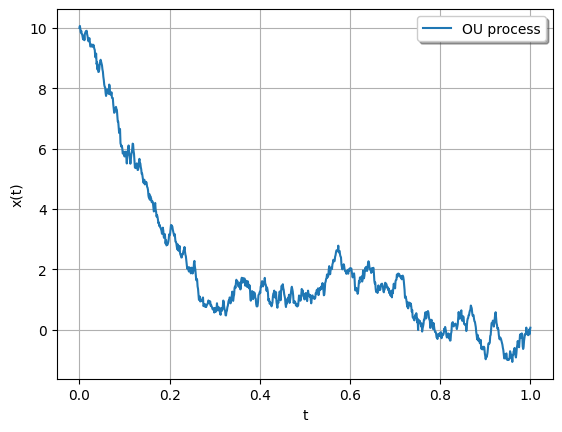

In [ ]:
T = 1
Nx = 1
Nt = 1000

init_state = 10 * np.ones(Nx)

theta = 5
mu = 0
sigma = 3.5
params = [theta, mu, sigma]

OUProcess = OrnsteinUhlenbeckProcess(params, T, Nx, Nt, init_state)
t_data, x_data = OUProcess.EulerSolution()
plt.plot(t_data, x_data, label = 'OU process')

plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

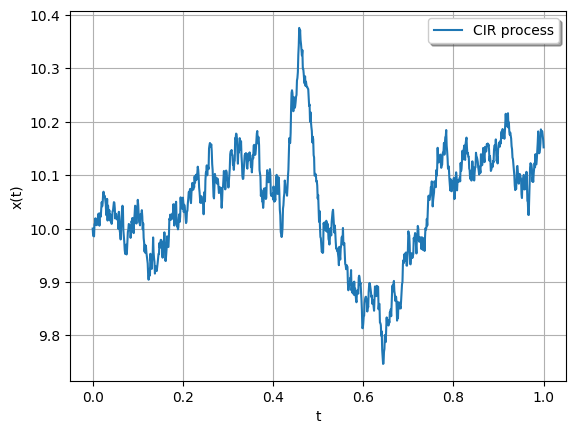

In [ ]:
theta1 = 2
theta2 = 0.2
theta3 = 0.15
params = [theta1, theta2, theta3]

CIRProcess = CoxIngersollRossProcess(params, T, Nx, Nt, init_state)
t_data, x_data = CIRProcess.EulerSolution()
plt.plot(t_data, x_data, label = 'CIR process')

plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

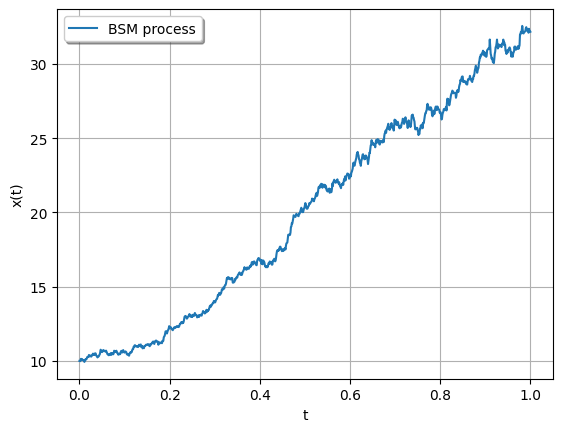

In [ ]:
theta1 = 1.0
theta2 = 0.2
params = [theta1, theta2]

BSMProcess = BlackScholesMertonProcess(params, T, Nx, Nt, init_state)
t_data, x_data = BSMProcess.EulerSolution()
plt.plot(t_data, x_data, label = 'BSM process')

plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

Task 2. Compute a confidence interval of the CIR process from the previous task. Plot the paths and a confidence interval.

In [ ]:
def zeta(sigma, theta, t, s):
    return sigma**2 / (4 * theta) * (1 - np.exp(-theta * (t - s)))

def CIRbounds(alpha_interval, params, t, s, xs):
    theta1, theta2, theta3 = params[0], params[1], params[2]
    theta = theta2
    beta = theta1 / theta2
    sigma = theta3

    k = 4  / sigma**2 * theta * beta
    lambd = 4 * theta / sigma**2  * np.exp(-theta * (t - s)) / (1 - np.exp(-theta * (t - s))) * xs
    ksi = norm.ppf(1 - alpha_interval / 2)

    b1 = zeta(sigma, theta, t, s) * (k + lambd - ksi * np.sqrt(2 * (k + 2 * lambd)))
    b2 = zeta(sigma, theta, t, s) * (k + lambd + ksi * np.sqrt(2 * (k + 2 * lambd)))
    return [b1, b2]


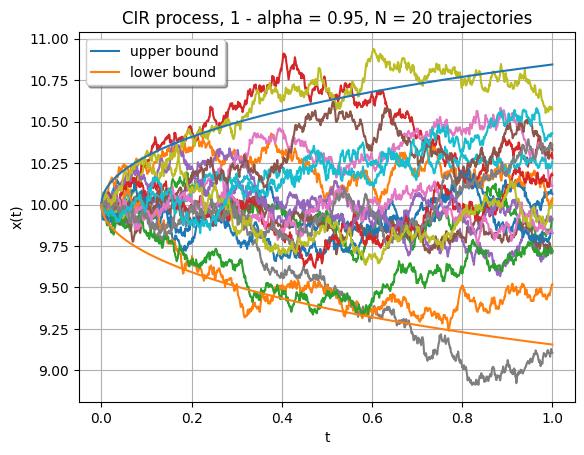

In [ ]:
theta1 = 2
theta2 = 0.2
theta3 = 0.15
params = [theta1, theta2, theta3]

Nx = 20

x0 = 10
init_state = x0 * np.ones(Nx)
alpha_interval = 0.05

CIRProcess = CoxIngersollRossProcess(params, T, Nx, Nt, init_state)
t_data, x_data = CIRProcess.EulerSolution()
for k in range(0, Nx):
    plt.plot(t_data, x_data[:,k])

low_bound_data = np.zeros_like(t_data)
up_bound_data = np.zeros_like(t_data)

for i in range(1, len(t_data)):
    bounds = CIRbounds(alpha_interval, params, t_data[i], 0, x0)
    low_bound_data[i] = bounds[0]
    up_bound_data[i] = bounds[1]
low_bound_data[0] = x0
up_bound_data[0] = x0
plt.plot(t_data, up_bound_data, label = f"upper bound")
plt.plot(t_data, low_bound_data, label = f"lower bound")

plt.title(f"CIR process, 1 - alpha = {1-alpha_interval}, N = {Nx} trajectories")
plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

Task 3. For the Ornstein-Uhlenbeck process
$$
dX_t = \theta(\mu - X_t)dt + \sigma dW_t, \quad \theta = 1, \quad \mu = 1.2, \quad \sigma = 0.3
$$
generate three paths: $X_0 = 0.0, 2.0, \mathcal{N}\left(\mu, \frac{\sigma^2}{2\theta}\right)$ and plot in graph.


In [ ]:
def print_mean_variance(x):
  empirical_mean = np.mean(x)
  empirical_variance = np.var(x)
  print(empirical_mean, empirical_variance)

0.463569949802379 0.030763554959040144
1.5797224860935037 0.04675328536139991
1.3050523814695392 0.004395844086502826


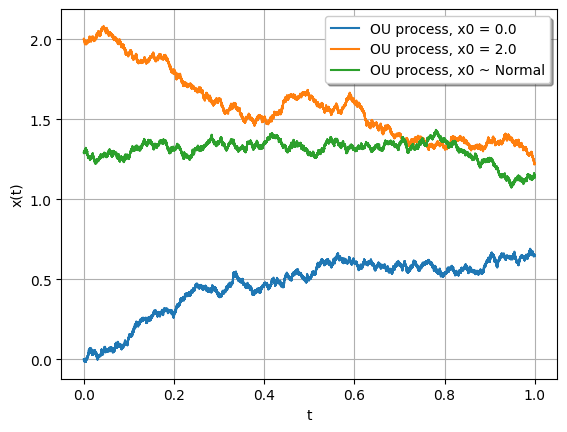

In [ ]:
T = 1
Nx = 1
Nt = 100000

theta = 1
mu = 1.2
sigma = 0.3
params = [theta, mu, sigma]

x0 = 0.0
init_state = x0 * np.ones(Nx)
OUProcess = OrnsteinUhlenbeckProcess(params, T, Nx, Nt, init_state)

t_data, x_data = OUProcess.EulerSolution()
print_mean_variance(x_data)
plt.plot(t_data, x_data, label = f'OU process, x0 = {x0}')

x0 = 2.0
init_state = x0 * np.ones(Nx)
OUProcess = OrnsteinUhlenbeckProcess(params, T, Nx, Nt, init_state)

t_data, x_data = OUProcess.EulerSolution()
print_mean_variance(x_data)
plt.plot(t_data, x_data, label = f'OU process, x0 = {x0}')


init_state = np.random.normal(mu, sigma**2/(2 * theta), size = Nx)
OUProcess = OrnsteinUhlenbeckProcess(params, T, Nx, Nt, init_state)

t_data, x_data = OUProcess.EulerSolution()
print_mean_variance(x_data)
plt.plot(t_data, x_data, label = f'OU process, x0 ~ Normal')

plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

Task. Define a path with the stationary distribution from the graph and prove mathematically.

In [ ]:
# Theoretical stationary mean and variance
theoretical_mean = mu
theoretical_variance = sigma**2 / (2 * theta)

theoretical_mean, theoretical_variance

(1.2, 0.045)

Task 4.  Design a process that stays in the interval $[0, 1]$ and mean-reverts
around $1/2$, generate a path and plot it in graph. Prove your solution.


Hint
$$
\mu(x) = \theta (1/2 - x), \quad \sigma(x) = \sigma \cdot x (1-x).
$$

That is
$$
dx = \theta (1/2 - x )dt + \sigma \cdot x (1-x) dW.
$$
Note: diffusion goes to zero at boundaries $\sigma(0) = \sigma(1) = 0$ and
mean-reverts  $⇒$ always stay in $[0, 1]$.

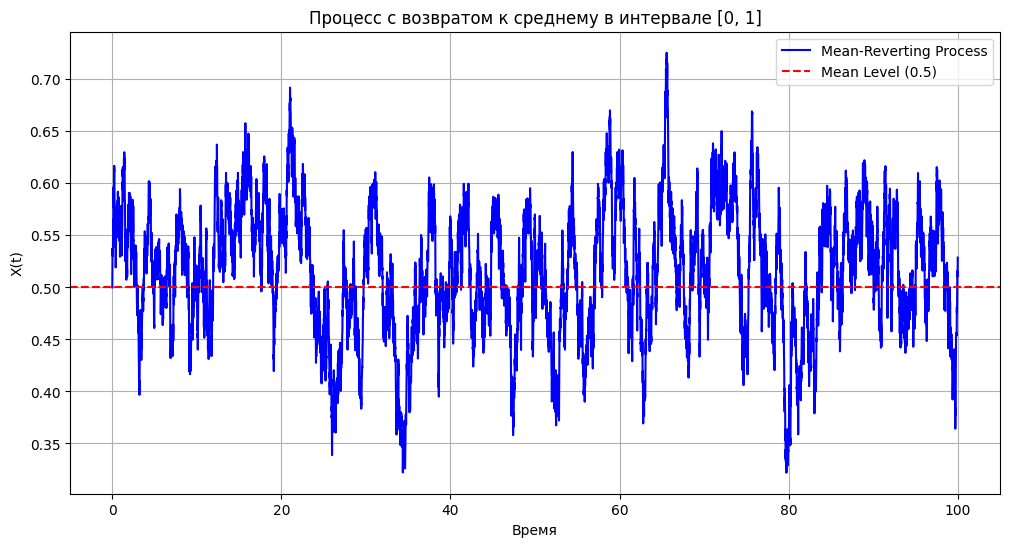

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Параметры для процесса
theta = 1.5   # скорость возврата к среднему
mu = 0.5      # среднее значение
sigma = 0.1   # волатильность
dt = 0.01     # временной шаг
T = 100        # общее время моделирования
N = int(T / dt)  # количество временных шагов

# Инициализация процесса
X = np.zeros(N)
X[0] = 0.5  # начальное значение, равное среднему

# Симуляция процесса с границами
for t in range(1, N):
    dX = theta * (mu - X[t-1]) * dt + sigma * np.sqrt(dt) * np.random.normal()
    X[t] = X[t-1] + dX

    # Применяем границы, чтобы процесс оставался в [0, 1]
    if X[t] < 0:
        X[t] = 0
    elif X[t] > 1:
        X[t] = 1

# Построение графика
time = np.linspace(0, T, N)
plt.figure(figsize=(12, 6))
plt.plot(time, X, label="Mean-Reverting Process", color="b")
plt.axhline(mu, color='r', linestyle='--', label="Mean Level (0.5)")
plt.xlabel("Время")
plt.ylabel("X(t)")
plt.title("Процесс с возвратом к среднему в интервале [0, 1]")
plt.legend()
plt.grid(True)
plt.show()


Task 5. Using the class template from Task 1, create classes and plot graphs for the following processes:

1.   Modified CIR model;
2.   Chan-Karolyi-Longstaff-Sanders family of models;
3.   Nonlinear mean reversion Ait-Sahalia model;
4.   Jacobi diffusion process;
5.   Ahn and Gao (inverse of Feller’s square root) model;
6.   Radial Ornstein-Uhlenbeck process.





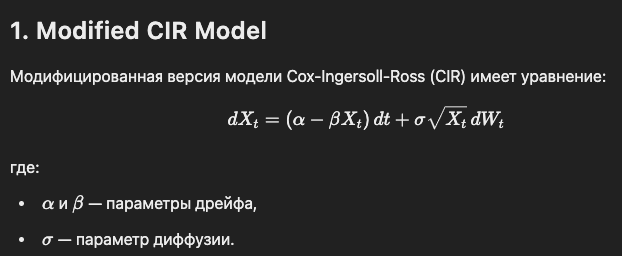

In [ ]:
class ModifiedCIRProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        super().__init__(params, T, Nx, Nt, init_state)
        self.alpha = params.get("alpha", 0.1)
        self.beta = params.get("beta", 0.1)
        self.sigma = params.get("sigma", 0.2)

        # Определяем коэффициенты
        self.bxt = lambda x: self.alpha - self.beta * x
        self.sigmaxt = lambda x: self.sigma * np.sqrt(np.maximum(x, 0))

    def sampler_init_state(self):
        return np.ones(self.Nx) * (self.init_state if self.init_state else 0.5)


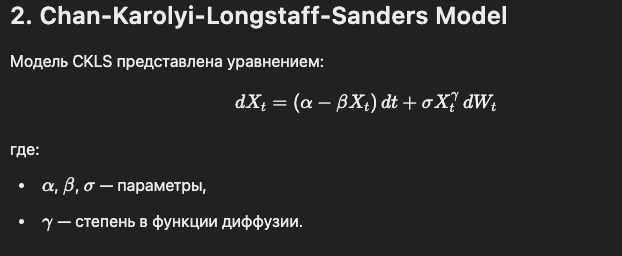

In [ ]:
class CKLSProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        super().__init__(params, T, Nx, Nt, init_state)
        self.alpha = params.get("alpha", 0.1)
        self.beta = params.get("beta", 0.1)
        self.sigma = params.get("sigma", 0.2)
        self.gamma = params.get("gamma", 1.0)

        # Определяем коэффициенты
        self.bxt = lambda x: self.alpha - self.beta * x
        self.sigmaxt = lambda x: self.sigma * np.power(np.maximum(x, 0), self.gamma)

    def sampler_init_state(self):
        return np.ones(self.Nx) * (self.init_state if self.init_state else 0.5)


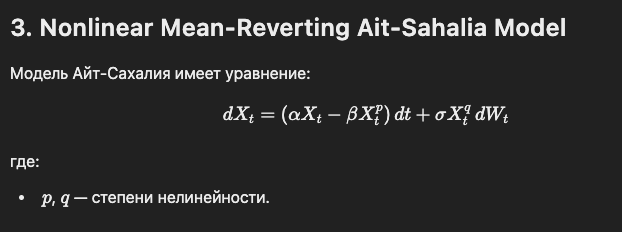

In [ ]:
class AitSahaliaProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        super().__init__(params, T, Nx, Nt, init_state)
        self.alpha = params.get("alpha", 0.1)
        self.beta = params.get("beta", 0.1)
        self.p = params.get("p", 1.5)
        self.q = params.get("q", 0.5)
        self.sigma = params.get("sigma", 0.2)

        # Определяем коэффициенты
        self.bxt = lambda x: self.alpha * x - self.beta * np.power(x, self.p)
        self.sigmaxt = lambda x: self.sigma * np.power(np.maximum(x, 0), self.q)

    def sampler_init_state(self):
        return np.ones(self.Nx) * (self.init_state if self.init_state else 0.5)


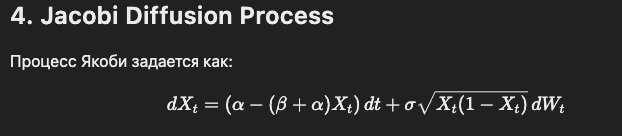

In [ ]:
class JacobiProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        super().__init__(params, T, Nx, Nt, init_state)
        self.alpha = params.get("alpha", 0.1)
        self.beta = params.get("beta", 0.1)
        self.sigma = params.get("sigma", 0.2)

        # Определяем коэффициенты
        self.bxt = lambda x: self.alpha - (self.beta + self.alpha) * x
        self.sigmaxt = lambda x: self.sigma * np.sqrt(np.maximum(x * (1 - x), 0))

    def sampler_init_state(self):
        return np.ones(self.Nx) * (self.init_state if self.init_state else 0.5)


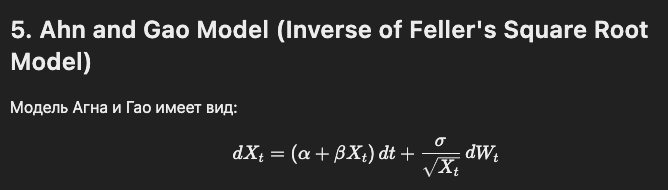

In [ ]:
class AhnGaoProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        super().__init__(params, T, Nx, Nt, init_state)
        self.alpha = params.get("alpha", 0.1)
        self.beta = params.get("beta", 0.1)
        self.sigma = params.get("sigma", 0.2)

        # Определяем коэффициенты
        self.bxt = lambda x: self.alpha + self.beta * x
        self.sigmaxt = lambda x: self.sigma / np.sqrt(np.maximum(x, 1e-4))

    def sampler_init_state(self):
        return np.ones(self.Nx) * (self.init_state if self.init_state else 0.5)


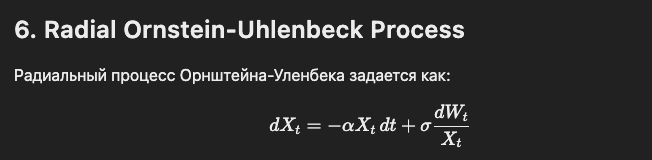

In [ ]:
class RadialOUProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        super().__init__(params, T, Nx, Nt, init_state)
        self.alpha = params.get("alpha", 0.1)
        self.sigma = params.get("sigma", 0.2)

        # Определяем коэффициенты
        self.bxt = lambda x: -self.alpha * x
        self.sigmaxt = lambda x: self.sigma / np.maximum(x, 1e-4)

    def sampler_init_state(self):
        return np.ones(self.Nx) * (self.init_state if self.init_state else 1.0)


<Figure size 1000x600 with 0 Axes>

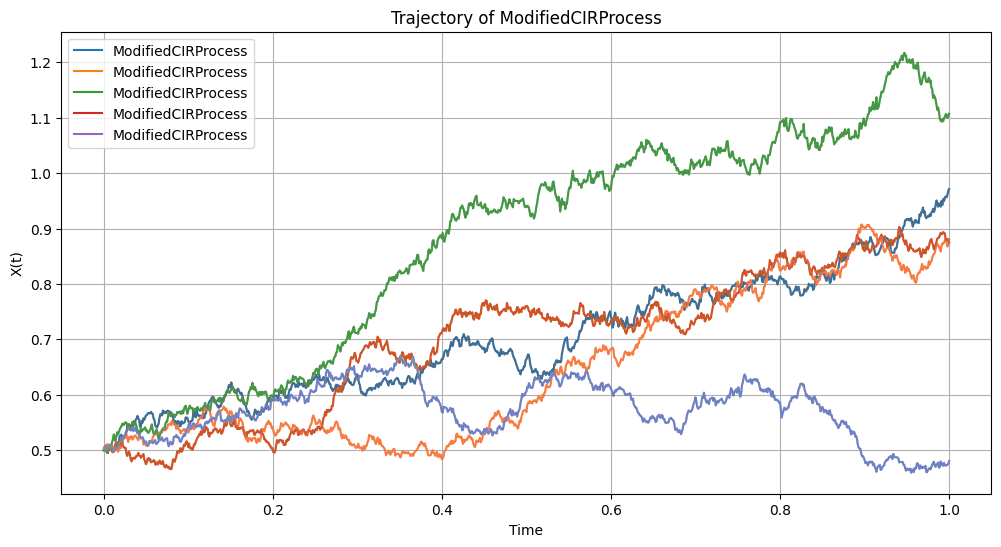

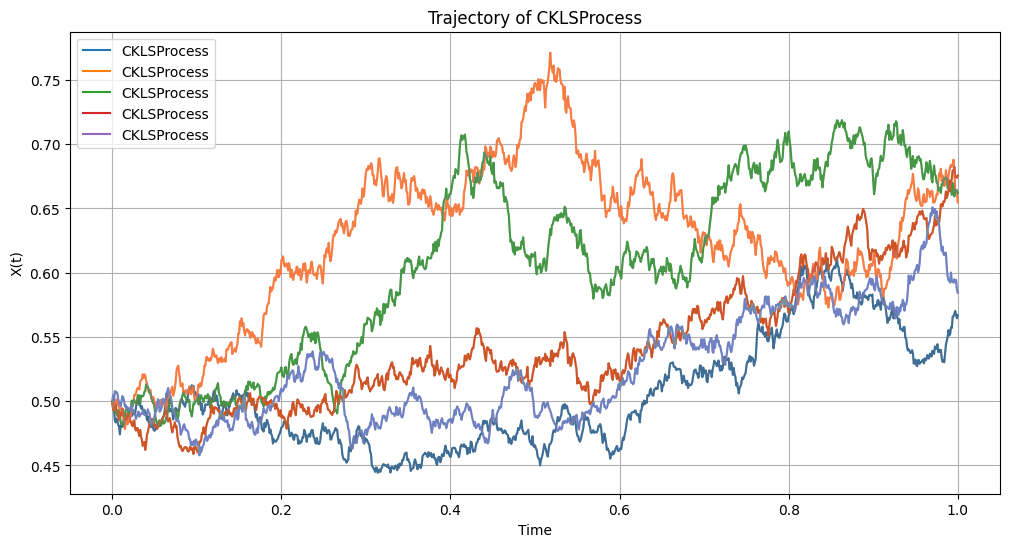

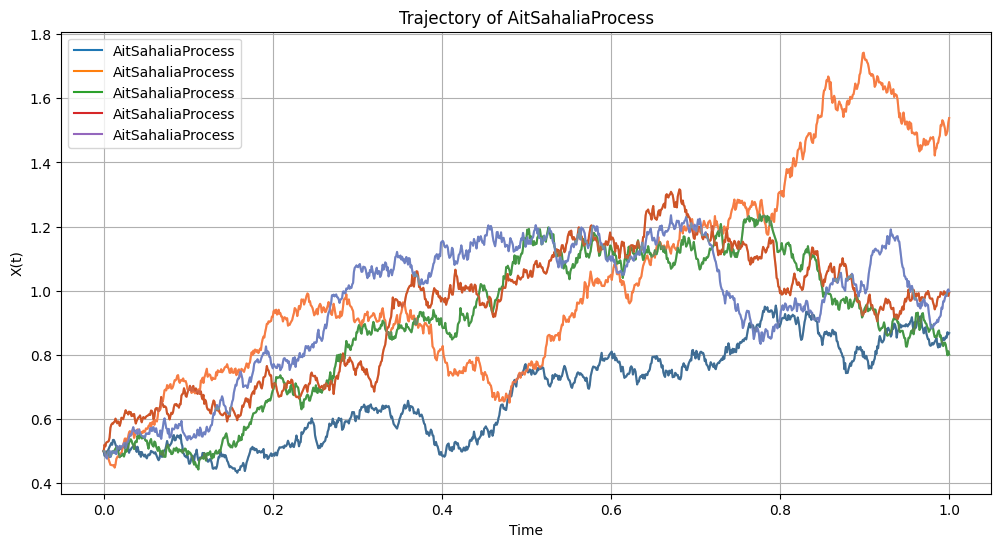

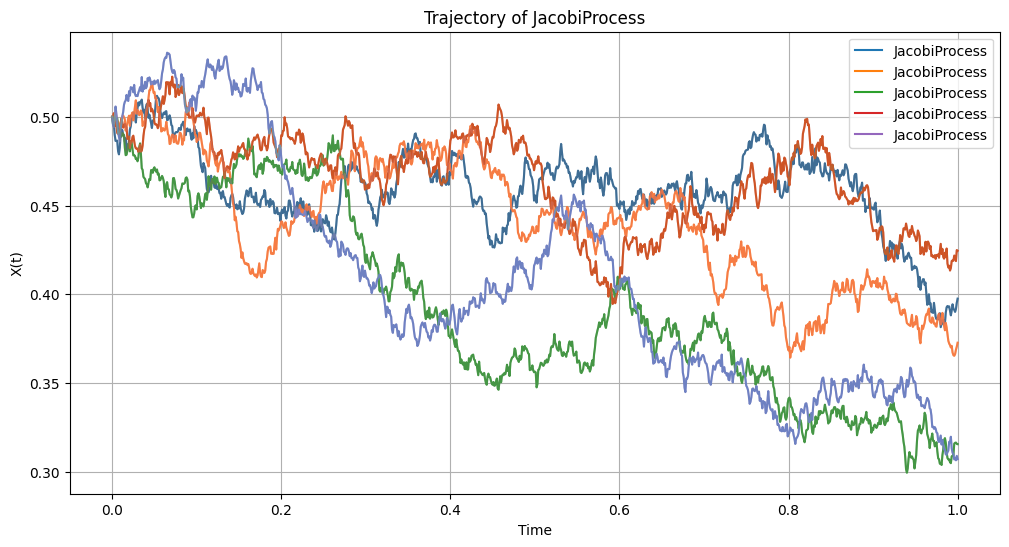

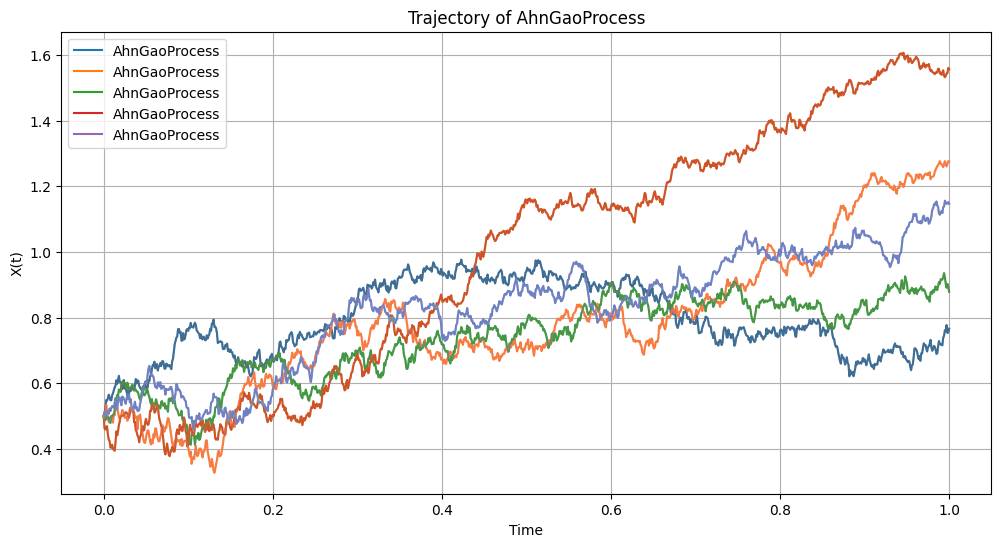

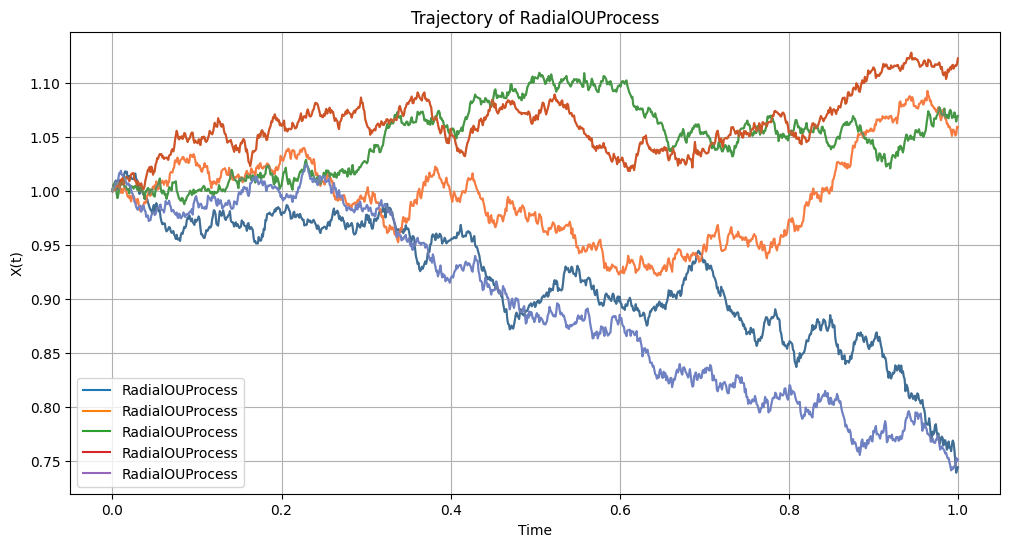

In [ ]:
import matplotlib.pyplot as plt

# Задаем размер графиков и параметры
plt.figure(figsize=(10, 6))

for ProcessClass, params in [
    (ModifiedCIRProcess, {"alpha": 0.5, "beta": 0.3, "sigma": 0.2}),
    (CKLSProcess, {"alpha": 0.2, "beta": 0.1, "sigma": 0.3, "gamma": 1.5}),
    (AitSahaliaProcess, {"alpha": 1.0, "beta": 0.5, "sigma": 0.4, "p": 2, "q": 0.5}),
    (JacobiProcess, {"alpha": 0.3, "beta": 0.6, "sigma": 0.2}),
    (AhnGaoProcess, {"alpha": 0.4, "beta": 0.2, "sigma": 0.3}),
    (RadialOUProcess, {"alpha": 0.1, "sigma": 0.1})
]:
    # Инициализация процесса
    process = ProcessClass(params, T=1, Nx=5, Nt=1000)
    t_data, x_data = process.EulerSolution()

    # Усредняем траектории по 100 точкам
    mean_trajectory = np.mean(x_data, axis=1)

    # Построение усредненной траектории и нескольких выборочных траекторий
    plt.figure(figsize=(12, 6))
    plt.plot(t_data, x_data, label=ProcessClass.__name__)
    for i in range(5):  # выводим 5 случайных траекторий для наглядности
        plt.plot(t_data, x_data[:, i], alpha=0.3)

    # Настройка графика
    plt.title(f"Trajectory of {ProcessClass.__name__}")
    plt.xlabel("Time")
    plt.ylabel("X(t)")
    plt.legend()
    plt.grid(True)
    plt.show()


Task 6.

Let $$X(t)=e^{-\kappa t} X_0 + \theta (1-e^{-\kappa t}) + \sigma e^{-\kappa t} \int_0^t e^{\kappa s}\sqrt{X(t)}dW(s)$$ be extract solution for CIR model.


 Expand the functionality of the class CoxIngersollRossProcess(StochasticProcess) and compute the first and second moments of the extract solution $\mathbb{E}\{X^n(t)\}$ using the general formula [Jafari, 2017]
$$
\mathbb{E}\{X^n(t)\} = \sum_{j=0}^{[n/2]}A^{n-2j}(t)B^{2j}(t)
\left(\frac{1}{2\kappa}(e^{2\kappa t} - 1)\right)^{2j}, \quad \forall n \in \mathbb{N},
$$
where $A(t)=e^{-\kappa t X_0} + \theta(1-e^{-\kappa t})$,
$B(t)=\sigma e^{-\kappa t}$, $[n/2]$ denotes the greatest integer less than or equal to $\frac{n}{2}$ and $\kappa=1$, $\theta =0.45$, $\sigma=1$.

Jafari M.A. [The Moments for Solution of the Cox-Ingersoll-Ross Interest Rate Model](https://www.sciepub.com/portal/downloads?doi=10.12691/jfe-5-1-4&filename=jfe-5-1-4.pdf) / M.A. Jafari, S. Abbasian // Journal of Finance
and Economics. – 2017. – Vol. 5, № 1. – P. 34—37

In [ ]:
import numpy as np

class CoxIngersollRossProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        super().__init__(params, T, Nx, Nt, init_state)

        # Параметры CIR-модели: [theta, kappa, sigma]
        self.theta = params[0]
        self.kappa = params[1]
        self.sigma = params[2]

        # Определение функций сноса и волатильности
        self.bxt = lambda x: self.theta - self.kappa * x
        self.sigmaxt = lambda x: self.sigma * np.sqrt(np.maximum(x, 0))

    def sampler_init_state(self):
        # Начальное состояние
        return self.theta / self.kappa * np.ones(self.Nx)

    def A(self, t):
        # Функция A(t)
        return np.exp(-self.kappa * t) * self.init_state + self.theta * (1 - np.exp(-self.kappa * t))

    def B(self, t):
        # Функция B(t)
        return self.sigma * np.exp(-self.kappa * t)

    def moment(self, n, t):
        # Вычисление n-го момента по формуле
        A_t = self.A(t)
        B_t = self.B(t)
        moment_value = 0
        for j in range(n // 2 + 1):
            coeff = (A_t ** (n - 2 * j)) * (B_t ** (2 * j))
            factor = (1 / (2 * self.kappa) * (np.exp(2 * self.kappa * t) - 1)) ** j
            moment_value += coeff * factor
        return moment_value

    def first_moment(self, t):
        # Первый момент E{X(t)}
        return self.moment(1, t)

    def second_moment(self, t):
        # Второй момент E{X^2(t)}
        return self.moment(2, t)

In [ ]:
# Заданные параметры: theta = 0.45, kappa = 1, sigma = 1
params = [0.45, 1, 1]
T = 1.0  # Конечное время
Nx = 1000  # Число траекторий
Nt = 100  # Число временных шагов

# Создаем процесс и вычисляем моменты
cir_process = CoxIngersollRossProcess(params, T, Nx, Nt, init_state=0.5)
t = 1.0  # Момент времени для вычисления момента

# Вычисление первого и второго момента
first_moment = cir_process.first_moment(t)
second_moment = cir_process.second_moment(t)

print("Первый момент E[X(t)]:", first_moment)
print("Второй момент E[X^2(t)]:", second_moment)


Первый момент E[X(t)]: 0.46839397205857214
Второй момент E[X^2(t)]: 0.6517252714425001


Task 7. Suppose we have a standard (zero-mean) Ornstein-Uhlenbeck process defined by
$$
dX_t = -\theta X_t dt + \sigma dW_t, \quad X_0 = x_0,
$$
where $\sigma$ is interpreted as the volatility, and $\theta$ is the speed of reversion.

Define a half-life at time $s$ as the time $h$ such that $𝔼(x_h|x_s)=\frac{1}{2}x_s$. That is, how long until half the deviation from the mean is, in expectation, lost.

This is easy to compute because
\begin{align}
  \frac{1}{2}x_s & =  𝔼(x_h|x_s) \\
                 & = x_s\exp(-\theta h)
\end{align}
and we can cancel the $x_s$ terms to give
\begin{align}
  \frac{1}{2} = \exp(-\theta h)
\end{align}
which rearranges to
\begin{align}
  h = \frac{\ln(2)}{\theta}
\end{align}
The cancellation of $x_s$ means that a half-life does not depend on either $s$ or $x_s$ and so we are entitled to call it "the" half-life of the process.

As one can see, the half-life is a constant for an Ornstein-Uhlenbeck process.

